In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor-mri-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1608934%2F2645886%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240904%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240904T004153Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D35895a631c1e0a594e9192ba3ac8b8e4c9c77d9baccbd58ea341c49d7c021f3e2bbe9f8f0138dff2348340ffb46a08049740caa9456658d9be58330cf24506576839c51418be049e0b7969953cc95d160e7226b9fd2bf6deb6581ffb3174c40eebf2da0c91bcc7c83b105936604e49b4ed6d8b38e92b4d362daaaa2505768cb860f00125151cda4f4dfc33d7aeded44ecbef0348f1d310b39db3b56d7f24c8d433c8254345c72824bb7026dd35fcecbf07161bca39bce6d549179c13bc6dfbd6ada1c036e6cc7a77e19aebf9dc389a61ef84836b01b3b566c762160cabb3ba7616b7833ab548148814a2452a5e6f63c89c07126b6f6e9a80a23f247ecd0c4a47'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 155791278 bytes downloaded
Downloaded and uncompressed: brain-tumor-mri-dataset
Data source import complete.


In [2]:
%matplotlib inline

In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/brain-tumor-mri-dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['Training', 'Testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


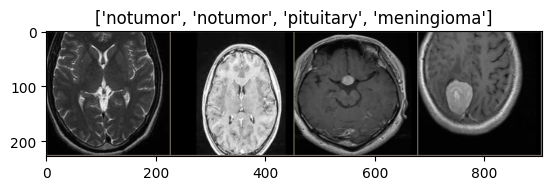

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Training']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Testing']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'Training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'Testing' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Testing']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to the number of classes.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s] 


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
Training Loss: 0.7989 Acc: 0.7120
Testing Loss: 0.4261 Acc: 0.8574

Epoch 1/24
----------
Training Loss: 0.5253 Acc: 0.8242
Testing Loss: 0.1788 Acc: 0.9352

Epoch 2/24
----------
Training Loss: 0.4397 Acc: 0.8552
Testing Loss: 0.2315 Acc: 0.9191

Epoch 3/24
----------
Training Loss: 0.4003 Acc: 0.8666
Testing Loss: 0.1382 Acc: 0.9504

Epoch 4/24
----------
Training Loss: 0.3534 Acc: 0.8841
Testing Loss: 0.1148 Acc: 0.9580

Epoch 5/24
----------
Training Loss: 0.3133 Acc: 0.8937
Testing Loss: 0.1170 Acc: 0.9680

Epoch 6/24
----------
Training Loss: 0.2872 Acc: 0.9051
Testing Loss: 0.1724 Acc: 0.9420

Epoch 7/24
----------
Training Loss: 0.2019 Acc: 0.9328
Testing Loss: 0.0508 Acc: 0.9878

Epoch 8/24
----------
Training Loss: 0.1809 Acc: 0.9456
Testing Loss: 0.0451 Acc: 0.9870

Epoch 9/24
----------
Training Loss: 0.1755 Acc: 0.9464
Testing Loss: 0.0490 Acc: 0.9870

Epoch 10/24
----------
Training Loss: 0.1685 Acc: 0.9457
Testing Loss: 0.0427 Acc: 0.9863

Epoch 11/

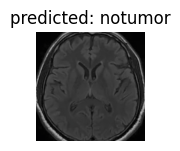

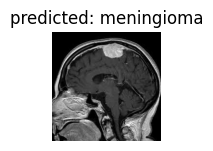

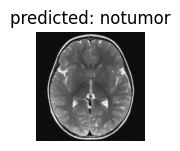

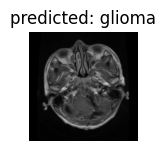

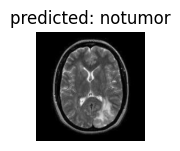

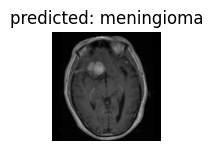

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Training Loss: 0.9669 Acc: 0.6283
Testing Loss: 0.6016 Acc: 0.7757

Epoch 1/24
----------
Training Loss: 0.8552 Acc: 0.6794
Testing Loss: 0.5339 Acc: 0.7979

Epoch 2/24
----------
Training Loss: 0.8035 Acc: 0.7026
Testing Loss: 0.4684 Acc: 0.8200

Epoch 3/24
----------
Training Loss: 0.8539 Acc: 0.6914
Testing Loss: 0.5463 Acc: 0.8169

Epoch 4/24
----------
Training Loss: 0.8165 Acc: 0.7006
Testing Loss: 0.6432 Acc: 0.7719

Epoch 5/24
----------
Training Loss: 0.8603 Acc: 0.6864
Testing Loss: 0.5177 Acc: 0.8154

Epoch 6/24
----------
Training Loss: 0.8256 Acc: 0.7015
Testing Loss: 0.4721 Acc: 0.8162

Epoch 7/24
----------
Training Loss: 0.6771 Acc: 0.7409
Testing Loss: 0.4647 Acc: 0.8200

Epoch 8/24
----------
Training Loss: 0.6746 Acc: 0.7409
Testing Loss: 0.4827 Acc: 0.8169

Epoch 9/24
----------
Training Loss: 0.6714 Acc: 0.7425
Testing Loss: 0.4836 Acc: 0.8146

Epoch 10/24
----------
Training Loss: 0.6584 Acc: 0.7474
Testing Loss: 0.4819 Acc: 0.8207

Epoch 11/

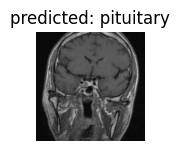

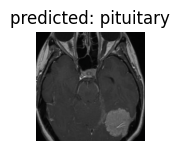

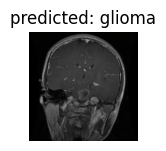

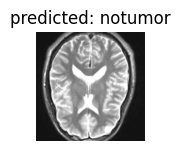

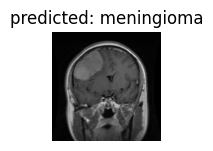

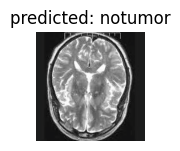

In [ ]:
visualize_model(model_conv)